## 概述

由于RepPointsDetector没有对backbone和neck进行修改, 因此直接继承SingleStageDetetor即可，也可以不写相应的代码，重点在Head上。
RepPointsHead可以从AnchorFreeHead继承改写，前面提到对于继承AnchorFreeHead，需要实现下面几个函数

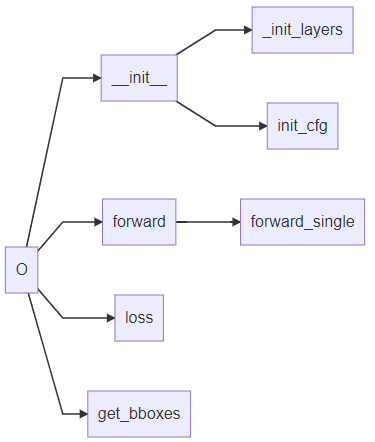

- __init__: 创建并初始化模块
- forward： 逐次执行模块
- loss：训练时候根据forward结果和gt计算loss
- get_bboxes：根据forward结果获得bbox

另外AnchorFreeHead中定义了一个未被调用的抽象函数也需要实现一下

- get_targets


@HEADS.register_module()是在工厂管理器中注册该类，后面可以使用HEADS.build(cfg)来进行创建, cfg是配置文件定义的dict, 对应相关代码构造函数列表

In [1]:
from mmdet.models.dense_heads.anchor_free_head import AnchorFreeHead
from mmdet.models.builder import HEADS

@HEADS.register_module()
class MyRepPointsHead0(AnchorFreeHead):
    def __init__(self, num_classes, in_channels, *args, **kwargs):
        super(MyRepPointsHead0, self).__init__(num_classes, in_channels, *args, **kwargs)
    
    def forward(self, *args, **kwargs):
        pass
    
    def loss(self, *args, **kwargs):
        pass
    
    def get_bboxes(self, *args, **kwargs):
        pass
    
    def get_targets(self, *args, **kwargs):
        pass

In [2]:
cfg = dict(
    type="MyRepPointsHead0",
    num_classes=80,
    in_channels=256
)

# 输出的是AnchorFreeHead搭建的网络
HEADS.build(cfg, default_args=dict())

MyRepPointsHead0(
  (loss_cls): FocalLoss()
  (loss_bbox): IoULoss()
  (cls_convs): ModuleList(
    (0): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate): ReLU(inplace=True)
    )
    (1): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate): ReLU(inplace=True)
    )
    (2): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate): ReLU(inplace=True)
    )
    (3): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate): ReLU(inplace=True)
    )
  )
  (reg_convs): ModuleList(
    (0): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate): ReLU(inplace=True)
    )
    (1): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate): ReLU(inplace=True)
   

## DataLoader(用于测试)

在介绍网络之前，我们先介绍，如何加载测试数据

In [3]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets import build_dataloader, build_dataset

data_root = 'D:\\mapping\\TOV_mmdetection\\data\\tiny_set\\'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    # dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
#     dict(type='Resize', scale_factor=[1.0], keep_ratio=True),
    dict(type='Resize', scale_factor=[0.5], keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_bboxes_ignore']),  # 定义输出
]

cfg = dict(
    type='CocoFmtDataset',
    ann_file=data_root + 'mini_annotations/tiny_set_train_sw640_sh512_all_erase.json',
    img_prefix=data_root + 'erase_with_uncertain_dataset/train/',
    pipeline=train_pipeline
)

# dataset = DATASETS.build(cfg=cfg)
dataset = build_dataset(cfg)
dataloader = build_dataloader(dataset, samples_per_gpu=2, workers_per_gpu=1, num_gpus=1,
                                dist=False, shuffle=True, seed=None)   # invoke DataLoader

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
valid image count:  3206


In [4]:
"""
DataContainer.data 取出里面的data
多GPU数据，还需要先scatter一下，分发到对应的GPU，即使用MMDataParallel.train_step (mmcv/parallel/data_parallel.py)中调用的scatter_kwargs(mmcv/parallel/scatter_gather.py)

img.data: (num_gpus, (B, 3, H, W))
gt_bboxes.data: (num_gpus, B, (num_boxes, 4))   # 由于不同图片gt数量可能不同，所以无法将不同图片的tensor stack成一个tensor，正能使用一个list
gt_bboxes_ignore.data: (num_gpus, B, (num_boxes, 4)) 
gt_labels.data: (num_gpus, B, (num_boxes,)), start form 0
"""

gid = 0 # gpu_id
img_id = 0

for i, data_batch in enumerate(dataloader):
    print(len(data_batch), data_batch.keys())
#     print(data_batch['img_metas'])
    # DataContainer --.data--> list(len=1) --[gpu_id]--> tensor(B, C, H, W)
    print('img:\t', type(data_batch['img']), type(data_batch['img'].data), len(data_batch['img'].data), type(data_batch['img'].data[gid]), data_batch['img'].data[gid].shape)
    print('gt_bboxes:\t', len(data_batch['gt_bboxes'].data), len(data_batch['gt_bboxes'].data[gid]), data_batch['gt_bboxes'].data[gid][img_id].shape)
    print()
    for k in data_batch:
        print(f'{k}:\t', data_batch[k].data[gid][img_id])
        print()
    break

5 dict_keys(['img_metas', 'img', 'gt_bboxes', 'gt_labels', 'gt_bboxes_ignore'])
img:	 <class 'mmcv.parallel.data_container.DataContainer'> <class 'list'> 1 <class 'torch.Tensor'> torch.Size([2, 3, 320, 256])
gt_bboxes:	 1 2 torch.Size([28, 4])

img_metas:	 {'filename': 'D:\\mapping\\TOV_mmdetection\\data\\tiny_set\\erase_with_uncertain_dataset/train/labeled_images/bb_V0034_I0001160.jpg', 'ori_filename': 'labeled_images/bb_V0034_I0001160.jpg', 'ori_shape': (640, 512, 3), 'img_shape': (320, 256, 3), 'pad_shape': (320, 256, 3), 'scale_factor': array([0.5, 0.5, 0.5, 0.5], dtype=float32), 'flip': True, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}

img:	 tensor([[[ 0.4851,  0.4851,  0.4851,  ...,  0.4851,  0.4851,  0.4851],
         [ 0.4851,  0.4851,  0.4851,  ...,  0.4851,  0.4851,  0.4851],
         [ 0.4851,  0.4851,  0.4851,  ...,  0.4851,  0.4851,  0.48

In [2]:
# 创建一个Pseudo输入

import torch

def gen_pseudo_inputs(B, C, H, W, num_levels, device):
    feats = [torch.randn(B, C, H//(2**l), W//(2**l)).to(device) for l in range(num_levels)]
    gt_bboxes = [torch.rand(2, 4).to(device) * 400 for _ in range(len(feats))]
    for i, bbox in enumerate(gt_bboxes):
        gt_bboxes[i][:, 2:] = gt_bboxes[i][:, :2] + gt_bboxes[i][:, 2:] / 10
    gt_bboxes_ignore = [torch.empty(0, 4).to(device) for _ in range(len(feats))]
    gt_labels = [torch.zeros(2).to(device) for _ in range(len(feats))]
    img_metas = [{"pad_shape": (H*32, W*32, 3)} for _ in range(len(feats))]
    return feats, gt_bboxes, gt_labels, img_metas, gt_bboxes_ignore

In [6]:
from setting import model as model_cfg
from mmdet.models.builder import DETECTORS

class MyDict(dict):
    @staticmethod
    def to(d: dict):
        for k, v in d.items():
            if isinstance(v, dict) and not isinstance(v, MyDict):
                d[k] = MyDict.to(v)
        return MyDict(d)
    
    def __getattr__(self, k):
        return self[k]

model_cfg = MyDict.to(model_cfg)

# model_cfg.pop('pretrained')
ori_model = DETECTORS.build(model_cfg)

## 网络结构
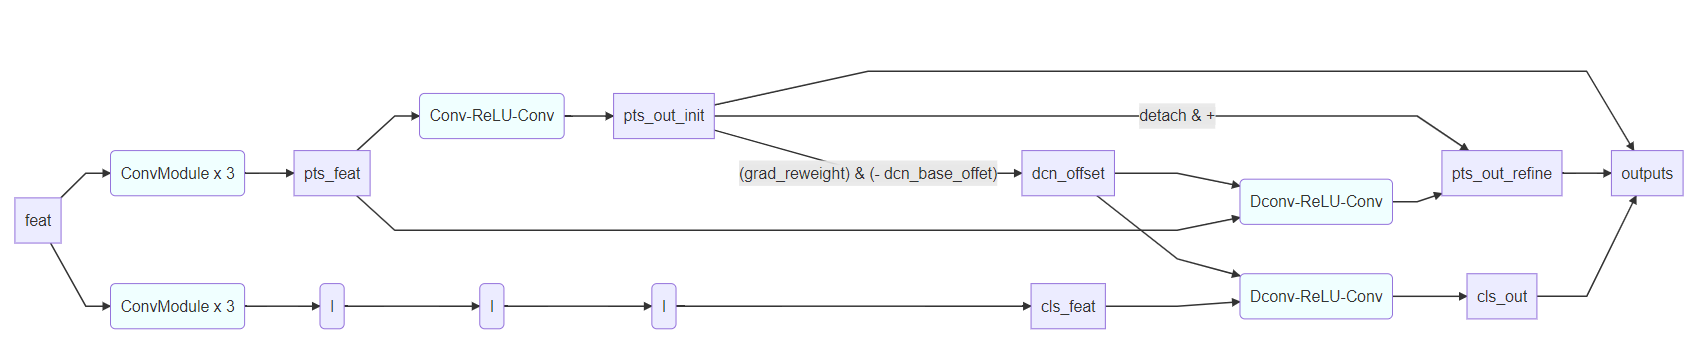

与网络结构创建相关的是创建网络结构的__init__和使用网络结构的forward

### 1. 网络结构创建：\_\_init\_\_

RepPoints的结构如下


我们要实现上面的结构，可以参考AnchorFreeHead的实现，如下
- AnchorFreeHead在__init__中调用了_init_layers进行初始化
- _init_reg_convs和_init_cls_convs结构非常一致，而_init_predictor又很简单，因此可以合并为一个函数

```
@HEADS.register_module()
class AnchorFreeHead(BaseDenseHead, BBoxTestMixin):

    def __init__(self,
        ......
        self._init_layers()

    def _init_layers(self):
        """Initialize layers of the head."""
        self._init_cls_convs()
        self._init_reg_convs()
        self._init_predictor()

    def _init_cls_convs(self):
        """Initialize classification conv layers of the head."""
        self.cls_convs = nn.ModuleList()
        for i in range(self.stacked_convs):
            chn = self.in_channels if i == 0 else self.feat_channels
            if self.dcn_on_last_conv and i == self.stacked_convs - 1:
                conv_cfg = dict(type='DCNv2')
            else:
                conv_cfg = self.conv_cfg
            self.cls_convs.append(
                ConvModule(
                    chn,
                    self.feat_channels,
                    3,
                    stride=1,
                    padding=1,
                    conv_cfg=conv_cfg,
                    norm_cfg=self.norm_cfg,
                    bias=self.conv_bias))
                 
    def _init_reg_convs(self):
        ...

    def _init_predictor(self):
        """Initialize predictor layers of the head."""
        self.conv_cls = nn.Conv2d(
            self.feat_channels, self.cls_out_channels, 3, padding=1)
        self.conv_reg = nn.Conv2d(self.feat_channels, 4, 3, padding=1)
```

参考AnchorFreeHead我们可以写出RepPointsHead

<font color='red'>Attention: all defined use by _init_layers should define before super().__init__ called.</font>

In [3]:
from mmcv.ops import DeformConv2d
from mmcv.cnn import ConvModule
import numpy as np
from torch import nn


class MyRepPointsHead1(MyRepPointsHead0):
    def __init__(self, num_classes, in_channels, 
                 num_points=9,
                 point_feat_channels=256,
                 *args, **kwargs):
        self.num_points = num_points
        self.point_feat_channels = point_feat_channels
        
        self.dcn_kernel = int(np.sqrt(num_points))
        self.dcn_pad = (self.dcn_kernel-1) // 2
        assert self.dcn_kernel * self.dcn_kernel == num_points, \
            'The points number should be a square number.'
        assert self.dcn_kernel % 2 == 1, \
            'The points number should be an odd square number.'
        
        self.cls_out_channels = num_classes
        
        super().__init__(num_classes, in_channels, *args, **kwargs)
        
    def _init_layers(self):
        """Initialize layers of the head."""
        self.cls_convs = nn.ModuleList()
        self.reg_convs = nn.ModuleList()
        for i in range(self.stacked_convs):  # stacked_convs=3
            chn = self.in_channels if i == 0 else self.feat_channels
            for module_list in [self.cls_convs, self.reg_convs]:
                module_list.append(
                    ConvModule(
                        chn,
                        self.feat_channels,
                        3,
                        stride=1,
                        padding=1,
                        conv_cfg=self.conv_cfg,
                        norm_cfg=self.norm_cfg,
                        bias=self.conv_bias))
        self.reppoints_pts_init_conv = nn.Conv2d(self.feat_channels, self.point_feat_channels, 3, 1, 1)
        self.reppoints_pts_refine_conv = DeformConv2d(self.feat_channels, self.point_feat_channels, self.dcn_kernel, 1, self.dcn_pad)
        self.reppoints_cls_conv = DeformConv2d(self.feat_channels, self.point_feat_channels, self.dcn_kernel, 1, self.dcn_pad)
        
        pts_out_dim = 2 * self.num_points
        self.reppoints_pts_init_out = nn.Conv2d(self.point_feat_channels, pts_out_dim, 1, 1, 0)
        self.reppoints_pts_refine_out = nn.Conv2d(self.point_feat_channels, pts_out_dim, 1, 1, 0)
        self.reppoints_cls_out = nn.Conv2d(self.point_feat_channels, self.cls_out_channels, 1, 1, 0)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, *args, **kwargs):
        pass
    
    def loss(self, *args, **kwargs):
        pass
    
    def get_bboxes(self, *args, **kwargs):
        pass
    
    def get_targets(self, *args, **kwargs):
        pass


### 2. 网络初始化：\_\_init\_\_

由于one stage的分类一般采用FocalLoss, 因此需要分类层的初始化prob为0.01，在AnchorFreeHead中分类层的名字叫conv_cls, 而其他层都是使用std=0.01的高斯分布初始化的,因此他的构造函数中初始化参数如下

```                 init_cfg=dict(
                     type='Normal',
                     layer='Conv2d',
                     std=0.01,
                     override=dict(
                         type='Normal',
                         name='conv_cls',
                         std=0.01,
                         bias_prob=0.01))
```
而对于RepPointsHead,应更改conv_cls为reppoints_cls_out

In [4]:
class MyRepPointsHead2(MyRepPointsHead1):
    def __init__(self, num_classes, in_channels, 
                 num_points=9,
                 point_feat_channels=256,
                 init_cfg=dict(
                     type='Normal',
                     layer='Conv2d',
                     std=0.01,
                     override=dict(
                         type='Normal',
                         name='reppoints_cls_out',  # change here
                         std=0.01,
                         bias_prob=0.01)),
                 *args, **kwargs):
        self.num_points = num_points
        self.point_feat_channels = point_feat_channels
        
        self.dcn_kernel = int(np.sqrt(num_points))
        self.dcn_pad = (self.dcn_kernel-1) // 2
        super().__init__(num_classes, in_channels, init_cfg=init_cfg, *args, **kwargs)  # change here
        
MyRepPointsHead2(
    num_classes=80,
    in_channels=256)

MyRepPointsHead2(
  (loss_cls): FocalLoss()
  (loss_bbox): IoULoss()
  (cls_convs): ModuleList(
    (0): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate): ReLU(inplace=True)
    )
    (1): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate): ReLU(inplace=True)
    )
    (2): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate): ReLU(inplace=True)
    )
    (3): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate): ReLU(inplace=True)
    )
  )
  (reg_convs): ModuleList(
    (0): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate): ReLU(inplace=True)
    )
    (1): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate): ReLU(inplace=True)
   

### 3. 网络执行：forward

In [5]:
from mmdet.core import multi_apply
import torch

class MyRepPointsHead3(MyRepPointsHead2):
    def __init__(self, num_classes, in_channels, 
                 gradient_mul=0.1,
                 *args, **kwargs):
        
        super().__init__(num_classes, in_channels, *args, **kwargs)
        
        dcn_base = np.arange(-self.dcn_pad, self.dcn_pad+1).astype(np.float64)
        dcn_base_x, dcn_base_y = np.meshgrid(dcn_base, dcn_base)
        dcn_base_offset = np.stack([dcn_base_y, dcn_base_x], axis=-1).reshape((-1, 2))
        self.dcn_base_offset = torch.tensor(dcn_base_offset).view(1, -1, 1, 1)
        
        self.gradient_mul = gradient_mul
        
    def forward(self, feats):
        return multi_apply(self.forward_single, feats)
    
    def forward_single(self, x):
        dcn_base_offset = self.dcn_base_offset.type_as(x)
        
        cls_feat, pts_feat = x, x
        for cls_conv, reg_conv in zip(self.cls_convs, self.reg_convs):
            cls_feat = cls_conv(cls_feat)
            pts_feat = reg_conv(pts_feat)
        
        pts_out_init = self.reppoints_pts_init_out(self.relu(self.reppoints_pts_init_conv(pts_feat)))
        
        pts_out_init_regrad = self.gradient_mul * pts_out_init + (1 - self.gradient_mul) * pts_out_init.detach()
        dcn_offset = pts_out_init_regrad - dcn_base_offset
        
        pts_out_refine = self.reppoints_pts_refine_out(self.relu(self.reppoints_pts_refine_conv(pts_feat, dcn_offset)))
        pts_out_refine = pts_out_refine + pts_out_init.detach()  # ******************** star 1
        cls_out = self.reppoints_cls_out(self.relu(self.reppoints_cls_conv(cls_feat, dcn_offset)))
        return cls_out, pts_out_init, pts_out_refine

In [ ]:
my_model = MyRepPointsHead3(
    num_classes=80,
    in_channels=256).to(0)

lib_model = HEADS.build(
    cfg=dict(
        type='RepPointsHead',
        num_classes=80,
        in_channels=256,
        transform_method='minmax'
    )
).to(0)

my_model.init_weights()
from mmcv.runner.checkpoint import get_state_dict
state_dict = get_state_dict(my_model)
lib_model.load_state_dict(state_dict)

In [10]:
# check our code with RepPointsHead implement in official library

feats = [torch.randn(2, 256, 8, 8).to(0)]
res1 = my_model(feats)
res2 = lib_model(feats)

def assert_same(l1, l2):
    if isinstance(l1, (tuple, list)) or isinstance(l2, (tuple, list)):
        for x1, x2 in zip(l1, l2):
            return assert_same(x1, x2)
    else:
        assert (l1 - l2).sum() == 0, f"{l1, l2}"
    return True
        
assert_same(res1, res2)

True

## loss

```
1. offset_to_pts 网络forward输出的pts_pred是9个点相对于预测点的offset，转换为9个点在图片中的位置：pts_pred -> 
    centers:
        point_generator.grid_points
        point_generator.valid_flags
    
2. points_to_bbox 将预测的pts转换为 box (x1, y1, x2, y2): pred_pts->pred_bbox

3. assigner.assgin 根据gt_bboxes给每个点分配label
    init stage   : center   , gt_bboxes
    refine stage : bbox_init.detach(), gt_bboxes

loss --> loss_single --> get_targets --> get_targets_single --> assign --> sample 

pts_pred_init + centers -> pred_init_pts
gts & centers -> labels, 
pts_pred_refine + centers -> pred_refine_pts

```

In [6]:
from mmdet.models.builder import build_loss
from mmdet.core import PointGenerator


def merge_dims(data, dims):
    assert tuple(range(dims[0], dims[-1]+1)) ==  tuple(dims), "merge dims must be continue interger"
    shape = data.shape
    new_shape = list()
    return data.reshpae(*shape[:dims[0]], -1, *shape[dims[-1]+1:])


class MyRepPointsHead4(MyRepPointsHead3):
    def __init__(self, num_classes, in_channels, 
                 point_strides=[8, 16, 32, 64, 128],
                 loss_cls=dict(type='FocalLoss', gamma=2.0, alpha=0.25, loss_weight=1.0,
                     use_sigmoid=True),
                 loss_bbox_init=dict(type='SmoothL1Loss', beta=1.0/9.0, loss_weight=0.5),   # ***************** star 2
                 loss_bbox_refine=dict(type='SmoothL1Loss', beta=1.0/9.0, loss_weight=1.0),
                 *args, **kwargs):
        
        super().__init__(num_classes, in_channels, *args, **kwargs)
        
        self.point_strides = point_strides
        self.point_generators = [PointGenerator() for _ in self.point_strides]
        
        self.use_sigmoid_cls = loss_cls.get('use_sigmoid', False)
        if self.use_sigmoid_cls:
            self.cls_out_channels = num_classes
        else:
            self.cls_out_channels = num_classes + 1
        self.loss_cls = build_loss(loss_cls)
        self.loss_bbox_init = build_loss(loss_bbox_init)
        self.loss_bbox_refine = build_loss(loss_bbox_refine)
        
    def get_points(self, featmap_sizes, img_metas, device):
        """
            point_generator.grid_points
            point_generator.valid_flags
            center: (B, num_levels, (H*W, 3))  # 3 is (x, y, stride)
        """
        num_levels = len(featmap_sizes)
        num_imgs = len(img_metas)
        
        multi_level_points = [self.point_generators[i].grid_points(featmap_sizes[i], self.point_strides[i], device) \
                              for i in range(num_levels)]
        points_list = [[points.clone() for points in multi_level_points] for i in range(num_imgs)]
        
        valid_flag_list = []
        for img_id, img_meta in enumerate(img_metas):
            multi_level_flags = []
            for i in range(num_levels):
                s = self.point_strides[i]
                feat_h, feat_w = featmap_sizes[i]
                h, w = img_meta['pad_shape'][:2]  # ??? pad_shape
                valid_feat_h = min(int(np.ceil(h/s)), feat_h)
                valid_feat_w = min(int(np.ceil(w/s)), feat_w)
                flags = self.point_generators[i].valid_flags((feat_h, feat_w), (valid_feat_h, valid_feat_w), device)
                multi_level_flags.append(flags)
            valid_flag_list.append(multi_level_flags)
            
        return points_list, valid_flag_list
    
    def offset_to_pts(self, center_list, pred_list):
        """
            center_list: (B, num_levels, (H*W, 3))  # 3 is (x, y, stride)
            pred_list: (num_levels, (B, C, H, W))   # C is (y0_off, x0_off, y1_off, x0_off, ...) follow offsets of DConv
            pts_list: (num_levels, (B, H*W, num_points*2))
        """
        pts_list = []
        for i in range(len(self.point_strides)):
            pts_lvl = []
            for img_id in range(len(center_list)):
                center = center_list[img_id][i][:, :2].repeat(1, self.num_points)
                pts_offset = pred_list[i][img_id].permute(1, 2, 0).view(-1, 2 * self.num_points)
                y_offset, x_offset = pts_offset[:, 0::2], pts_offset[:, 1::2]
                xy_offset = torch.stack([x_offset, y_offset], dim=-1).view(-1, 2* self.num_points)
                pts = center + xy_offset * self.point_strides[i]
                pts_lvl.append(pts)
            pts_list.append(torch.stack(pts_lvl, 0))
        return pts_list
    
    def points2bbox(self, pts, y_first=True):
        """
            pts: (X, num_points*2, ...)
        """
        pts = pts.view(pts.shape[0], -1, 2, *pts.shape[2:])
        pts_y = pts[:, :, 0, ...] if y_first else pts[:, :, 1, ...]
        pts_x = pts[:, :, 1, ...] if y_first else pts[:, :, 0, ...]
        
        bbox_left = pts_x.min(dim=1, keepdim=True)[0]
        bbox_right = pts_x.max(dim=1, keepdim=True)[0]
        bbox_up = pts_y.min(dim=1, keepdim=True)[0]
        bbox_bottom = pts_y.max(dim=1, keepdim=True)[0]
        bbox = torch.cat([bbox_left, bbox_up, bbox_right, bbox_bottom], dim=1)
        return bbox
        
    def loss(self, cls_scores, pts_preds_init, pts_preds_refine,
             gt_bboxes, gt_labels, img_metas, gt_bboxes_ignore=None):
        num_levels, B, device = len(cls_scores), cls_scores[0].shape[0], cls_scores[0].device
        featmap_sizes = [featmap.size()[-2:] for featmap in cls_scores]
        center_list, valid_flag_list = self.get_points(featmap_sizes, img_metas, device)
        pred_xy_init = self.offset_to_pts(center_list, pts_preds_init)
        
        center_list, valid_flag_list = self.get_points(featmap_sizes, img_metas, device)
        pred_xy_refine = self.offset_to_pts(center_list, pts_preds_refine)
        
        bbox_shifts = [self.points2bbox(pts_preds_init[i].detach()) * stride for i, stride in enumerate(self.point_strides)]
        bbox_init_list = []
        for img_id in range(B):
            center = center_list[img_id]
            multi_lvl_bbox = []
            for i in range(num_levels):
                bbox = center[i][:, :2].repeat(1, 2) + bbox_shifts[i][img_id].permute(1, 2, 0).view(-1, 4)
                multi_lvl_bbox.append(bbox)
            bbox_init_list.append(multi_lvl_bbox)
        return center_list, valid_flag_list, bbox_init_list, pred_xy_init, pred_xy_refine

In [7]:
inputs = gen_pseudo_inputs(2, 256, 2*32, 3*32, 5, device=0)

my_model = MyRepPointsHead4(
    num_classes=80,
    in_channels=256).to(0)

res = my_model(inputs[0])
res = my_model.loss(*res, *inputs[1:])

IndexError: index 2 is out of bounds for dimension 0 with size 2

In [34]:
class MyRepPointsHead5(MyRepPointsHead4):
    def __init__(self, num_classes, in_channels, *args, **kwargs):
        super().__init__(num_classes, in_channels, *args, **kwargs)
    
    def _point_target_single(self, flat_proposals, valid_flag, 
            gt_bboxes, gt_bboxes_ignore, gt_labels,
            label_channels=1, stage='init', unmap_outputs=True):
        """
            flat_proposals: [num_proposals, 4/ num_points*2]
        """
        inside_flags = valid_flags
        if not inside_flags.any():
            return (None, ) * 7
        
        if stage == 'init':
            assigner = self.init_assigner
            pos_weight = self.train_cfg.init.pos_weight
        else:
            assigner = self.refine_assigner
            pos_weight = self.train_cfg.refine.pos_weight
        assign_result = assigner.assign(proposals, gt_bboxes, gt_bboxes_ignore, None if self.sampling else gt_labels)
        sampling_result = self.sampler.sample(assign_result, proposals, gt_bboxes)
    
    def get_targets(self, proposals_list, valid_flag_list, 
                    gt_bboxes_list, img_metas, gt_bboxes_ignore_list=None, gt_labels_list=None,
                    stage='init', label_channels=1, unmap_outputs=True):
        """
            proposal_list: (B, num_levels, (H*W, 4 / num_points*2))
        """
        assert stage in ['init', 'refine']
        num_imgs = len(img_metas)
        assert len(proposals_list) == len(valid_flag_list) == num_imgs
        
        for i in range(num_imgs):
            assert len(proposals_list[i]) == len(valid_flag_list[i])
            proposals_list[i] = torch.cat(proposals_list[i])
            valid_flag_list[i] = torch.cat(valid_flag_list[i])
        
        if gt_bboxes_ignore_list is None:
            gt_bboxes_ignore_list = [None] * num_imgs
        if gt_labels_list is None:
            gt_labels_list = [None] * num_imgs
            
        = multi_apply(
            self._point_target_single, proposals_list, valid_flag_list, 
            gt_bboxes_list, gt_bboxes_ignore_list, gt_labels_list,
            stage=stage, label_channels=label_channels, unmap_outputs=unmap_outputs)
        
    def loss(self, cls_scores, pts_preds_init, pts_preds_refine,
             gt_bboxes, gt_labels, img_metas, gt_bboxes_ignore=None):
        center_list, super().loss(cls_scores, pts_preds_init, pts_preds_refine,
             gt_bboxes, gt_labels, img_metas, gt_bboxes_ignore=None)

1. point_init.detach() + point_refine
2. gt_bboxes_wh = (gt_bboxes[:, 2:] - gt_bboxes[:, :2]).clamp(min=1e-6)   # >>>>>>>>>>>>clamp